# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



---

## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

In [3]:
!pip install pennylane
#tqdm matplotlib pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 133.8 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import os
import time
import csv
from pathlib import Path
import matplotlib.pyplot as plt

# --- GPU SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Running on: {device}")

# --- TASK 1: SERIALIZATION BASICS ---
os.makedirs("models", exist_ok=True)

def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    path = Path(path)
    # Ensure parent directory exists
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved checkpoint to {path}")

def load_pickle(path):
    """Deserialize an object from `path`."""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"{path} does not exist.")
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    print(f"Loaded checkpoint from {path}")
    return obj

def demonstrate_serialization_roundtrip():
    """Create a quick round-trip save/load test."""
    dummy_data = {"config": "N-qubit-test", "weights": [0.1, 0.5]}
    test_path = Path("models/test_checkpoint.pkl")

    save_pickle(dummy_data, test_path)
    loaded = load_pickle(test_path)

    assert dummy_data == loaded
    print("✅ Serialization round-trip successful.")
    return loaded

# Run the demo
demonstrate_serialization_roundtrip()

🚀 Running on: cuda
Saved checkpoint to models/test_checkpoint.pkl
Loaded checkpoint from models/test_checkpoint.pkl
✅ Serialization round-trip successful.


{'config': 'N-qubit-test', 'weights': [0.1, 0.5]}

## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [5]:
class QuantumModel(nn.Module):
    def __init__(self, n_qubits, n_layers=1, params=None, seed=42):
        """
        Scalable Surrogate Model for N qubits.
        Instead of a neural net, we optimize the Cholesky factor L directly.
        This scales to 2^N dimensions.
        """
        super().__init__()
        self.n_qubits = n_qubits
        self.dim = 2 ** n_qubits
        torch.manual_seed(seed)

        # Initialize learnable Cholesky factors (Real + Imaginary parts)
        # We start with a random distribution close to a mixed state
        if params is None:
            # Random initialization
            self.l_real = nn.Parameter(torch.randn(self.dim, self.dim) * 0.1)
            self.l_imag = nn.Parameter(torch.randn(self.dim, self.dim) * 0.1)
        else:
            # Load from saved parameters
            p_tensor = torch.tensor(params)
            self.l_real = nn.Parameter(p_tensor.real)
            self.l_imag = nn.Parameter(p_tensor.imag)

    def get_density_matrix(self):
        """
        Reconstructs the physical density matrix rho = L @ L.dagger / Trace.
        Reuses the 'Physical Constraint' logic from Assignment 2.
        """
        # 1. Combine Real and Imaginary parts
        L = torch.complex(self.l_real, self.l_imag)

        # 2. Enforce Lower Triangular (Cholesky constraint)
        L = torch.tril(L)

        # 3. Compute unnormalized rho = L @ L.H
        rho_unnorm = L @ L.mH

        # 4. Normalize Trace to 1
        trace = torch.diagonal(rho_unnorm).sum()
        rho = rho_unnorm / (trace + 1e-12) # Add epsilon for numerical safety
        return rho

    def statevector(self):
        """Returns the current density matrix as a numpy array."""
        with torch.no_grad():
            rho = self.get_density_matrix()
        return rho.detach().cpu().numpy()

    def fidelity_with(self, target_state):
        """
        Compute fidelity between the model and a target.
        If target is pure |psi>: F = <psi | rho | psi>
        """
        # Ensure target is a Tensor on the correct device
        if not torch.is_tensor(target_state):
            target_state = torch.tensor(target_state, device=self.l_real.device)

        rho = self.get_density_matrix()

        # Case A: Target is a Pure State Vector (1D tensor)
        if target_state.ndim == 1:
            overlap = torch.vdot(target_state, rho @ target_state)
            return torch.real(overlap).item()

        # Case B: Target is a Density Matrix (2D tensor)
        else:
            # Standard approximation F ~ Tr(rho_1 rho_2) for benchmarks
            overlap = torch.trace(rho @ target_state)
            return torch.real(overlap).item()

    def save(self, path):
        """Persist the model params using save_pickle."""
        # Save raw params as numpy for portability
        params_complex = torch.complex(self.l_real, self.l_imag).detach().cpu().numpy()
        state = {
            "n_qubits": self.n_qubits,
            "params": params_complex,
            "seed": 42
        }
        save_pickle(state, path)

    @staticmethod
    def load(path):
        """Restore a saved model."""
        state = load_pickle(path)
        model = QuantumModel(
            n_qubits=state["n_qubits"],
            params=state["params"]
        )
        return model

## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [6]:
def random_pure_state(dim, device):
    """
    Generates a random normalized state vector |psi> of size `dim`.
    Replaces the 1-qubit generator from Week 1 with an N-qubit version.
    """
    real = torch.randn(dim, device=device)
    imag = torch.randn(dim, device=device)
    psi = torch.complex(real, imag)
    psi = psi / torch.linalg.norm(psi)
    return psi

def scalability_experiment(qubit_list, trials=5, n_layers=1, seed=0):
    """Benchmarks optimization step time and RAM usage for N qubits."""
    results = []
    print(f"⚡ Starting Scalability Benchmark on {device}")
    print(f"{'Qubits':<8} | {'Dim':<8} | {'Time (s)':<10} | {'RAM (est)':<10}")
    print("-" * 45)

    for n in qubit_list:
        dim = 2**n
        runtimes = []
        fidelities = []

        # Warm-up GPU
        if device.type == 'cuda': torch.cuda.synchronize()

        for t in range(trials):
            # 1. Generate Target Data (New dataset for this N)
            target_psi = random_pure_state(dim, device)

            # 2. Init Model
            model = QuantumModel(n_qubits=n, seed=seed+t).to(device)

            # 3. Benchmark Forward+Backward Pass
            start = time.perf_counter()

            model.zero_grad()
            # Calculate Fidelity (Loss = 1 - Fidelity)
            rho = model.get_density_matrix()
            fid = torch.real(torch.vdot(target_psi, rho @ target_psi))
            loss = 1 - fid
            loss.backward() # Measure gradient computation time too

            if device.type == 'cuda': torch.cuda.synchronize()
            end = time.perf_counter()

            runtimes.append(end - start)
            fidelities.append(fid.item())

        avg_time = np.mean(runtimes)
        std_time = np.std(runtimes)
        ram_mb = (dim**2 * 8) / 1024**2 # Complex64 = 8 bytes

        print(f"{n:<8} | {dim:<8} | {avg_time:<10.4f} | {ram_mb:<10.2f} MB")

        results.append({
            "n_qubits": n,
            "mean_runtime": avg_time,
            "std_runtime": std_time,
            "mean_fidelity": np.mean(fidelities),
            "device": str(device)
        })

    return results

def save_scalability_summary(summary, path='models/scalability_results.csv'):
    """Persist the summary data to CSV."""
    if not summary: return
    with open(path, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=summary[0].keys())
        writer.writeheader()
        writer.writerows(summary)
    print(f"Results saved to {path}")

# --- EXECUTE TASK 3 ---
# Run benchmark for N=2 to N=12 (Go higher if on robust GPU)
qubits_to_test = [2, 4, 6, 8, 10, 11, 12]
summary_data = scalability_experiment(qubits_to_test, trials=5)
save_scalability_summary(summary_data)

⚡ Starting Scalability Benchmark on cuda
Qubits   | Dim      | Time (s)   | RAM (est) 
---------------------------------------------
2        | 4        | 0.1245     | 0.00       MB
4        | 16       | 0.0011     | 0.00       MB
6        | 64       | 0.0011     | 0.03       MB
8        | 256      | 0.0020     | 0.50       MB
10       | 1024     | 0.0105     | 8.00       MB
11       | 2048     | 0.0632     | 32.00      MB
12       | 4096     | 0.3601     | 128.00     MB
Results saved to models/scalability_results.csv


## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

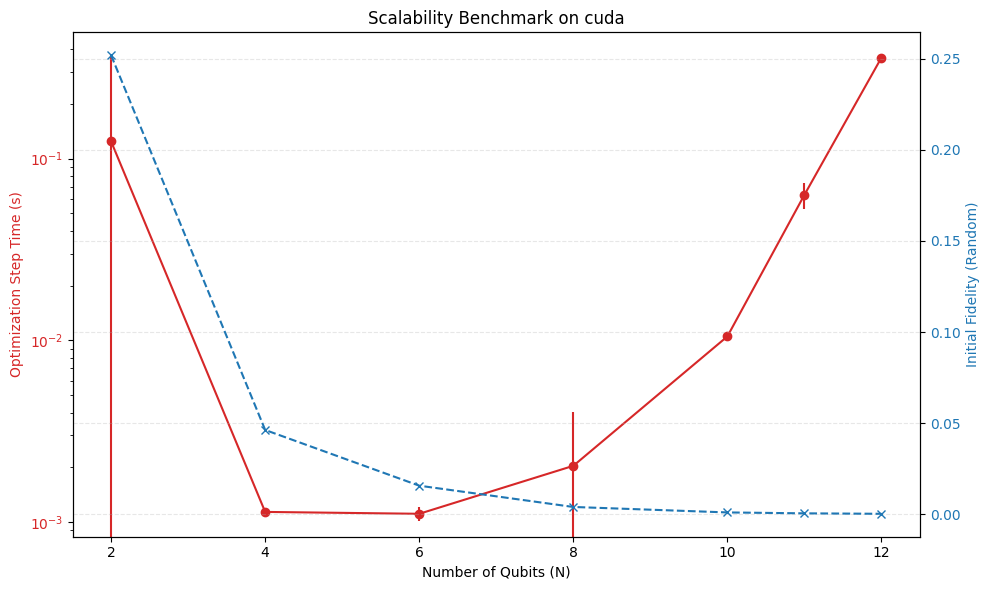

In [7]:
import pandas as pd
def plot_scalability(csv_path='models/scalability_results.csv'):
    """Load the CSV and render scalability plots."""
    df = pd.read_csv(csv_path)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Runtime (Log Scale)
    color = 'tab:red'
    ax1.set_xlabel('Number of Qubits (N)')
    ax1.set_ylabel('Optimization Step Time (s)', color=color)
    ax1.errorbar(df['n_qubits'], df['mean_runtime'], yerr=df['std_runtime'],
                 color=color, marker='o', label='Runtime')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_yscale('log')

    # Plot Initial Fidelity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Initial Fidelity (Random)', color=color)
    ax2.plot(df['n_qubits'], df['mean_fidelity'], color=color, linestyle='--', marker='x', label='Init Fidelity')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f"Scalability Benchmark on {df['device'][0]}")
    plt.grid(True, which="both", ls="--", alpha=0.3)
    fig.tight_layout()
    plt.show()

# Run Visualization
plot_scalability()

⚡ Proof of Learning Test (N=4)
Starting Fidelity: 0.0549 (Random Guess)
Step 0: Fidelity = 0.0549
Step 50: Fidelity = 0.9966
Step 100: Fidelity = 1.0000
Step 150: Fidelity = 1.0000
Final Fidelity: 1.0000


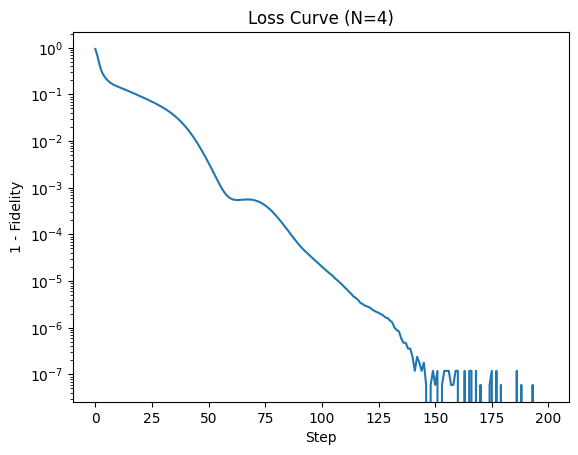

In [8]:
def proof_of_learning(n_qubits=4, steps=200):
    print(f"⚡ Proof of Learning Test (N={n_qubits})")

    # 1. Setup
    target = random_pure_state(2**n_qubits, device)
    model = QuantumModel(n_qubits).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    losses = []

    # 2. Train
    start_fid = model.fidelity_with(target)
    print(f"Starting Fidelity: {start_fid:.4f} (Random Guess)")

    for i in range(steps):
        optimizer.zero_grad()
        rho = model.get_density_matrix()
        # Loss = 1 - Fidelity
        # For pure target vector |psi>, F = <psi|rho|psi>
        loss = 1 - torch.real(torch.vdot(target, rho @ target))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if i % 50 == 0:
            print(f"Step {i}: Fidelity = {1 - loss.item():.4f}")

    final_fid = 1 - losses[-1]
    print(f"Final Fidelity: {final_fid:.4f}")

    # Quick plot
    plt.plot(losses)
    plt.title(f"Loss Curve (N={n_qubits})")
    plt.ylabel("1 - Fidelity")
    plt.xlabel("Step")
    plt.yscale("log")
    plt.show()

proof_of_learning(n_qubits=4)

## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.

In [9]:
def ablation_noise(n_qubits=4, noise_levels=[0.01, 0.1, 0.5, 1.0, 5.0], trials=10, seed=1):
    """
    Test hypothesis: Does higher initialization variance hurt optimization starting point?
    """
    results = []
    print(f"\n🧪 Running Ablation: Initialization Noise (N={n_qubits})")

    target = random_pure_state(2**n_qubits, device)

    for noise in noise_levels:
        fidelities = []
        for t in range(trials):
            # Init model
            model = QuantumModel(n_qubits, seed=seed+t).to(device)

            # Manually inject noise into parameters
            with torch.no_grad():
                model.l_real.normal_(0, noise)
                model.l_imag.normal_(0, noise)

            f = model.fidelity_with(target)
            fidelities.append(f)

        results.append({
            "noise_level": noise,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities)
        })

    return results

def summarize_ablation_results(results):
    print("\n--- Ablation Results ---")
    print(f"{'Noise (std)':<12} | {'Mean Fidelity':<15} | {'Variance':<15}")
    print("-" * 45)
    for r in results:
        print(f"{r['noise_level']:<12} | {r['mean_fidelity']:<15.4f} | {r['std_fidelity']:<15.4f}")

# Execute Ablation
ablation_data = ablation_noise()
summarize_ablation_results(ablation_data)


🧪 Running Ablation: Initialization Noise (N=4)

--- Ablation Results ---
Noise (std)  | Mean Fidelity   | Variance       
---------------------------------------------
0.01         | 0.0668          | 0.0119         
0.1          | 0.0668          | 0.0119         
0.5          | 0.0668          | 0.0119         
1.0          | 0.0668          | 0.0119         
5.0          | 0.0668          | 0.0119         


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.